### Importing library

In [16]:
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.signal import medfilt
import torch
import numpy as np
import neurokit2 as nk
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import os
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit  
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE


### loading data

In [ ]:

data_path = "E:\\WESAD\\"
ecg_list, eda_list, resp_list, lbl_list, subj_id_list = [], [], [], [], []

for subject in os.listdir(data_path):
    subj_dir = os.path.join(data_path, subject)
    if not os.path.isdir(subj_dir):
        continue

    try:
        subj_id = int(subject.replace('S', ''))
    except ValueError:
        print(f"Skipping invalid subject directory: {subject}")
        continue

    for fn in [f for f in os.listdir(subj_dir) if f.endswith(".pkl")]:
        pkl_path = os.path.join(subj_dir, fn)
        print(f"Loading {pkl_path}")
        try:
            with open(pkl_path, "rb") as f:
                data = pickle.load(f, encoding="latin1")
            
            chest = data["signal"]["chest"]
            ecg_raw  = torch.from_numpy(chest["ECG"].flatten()).float()
            eda_raw  = torch.from_numpy(chest["EDA"].flatten()).float()
            resp_raw = torch.from_numpy(chest["Resp"].flatten()).float()
            labels   = torch.from_numpy(data["label"].flatten()).long()
            subj_id_tensor = torch.full((ecg_raw.shape[0],), subj_id, dtype=torch.long)
            ecg_list.append(ecg_raw)
            eda_list.append(eda_raw)
            resp_list.append(resp_raw)
            lbl_list.append(labels)
            subj_id_list.append(subj_id_tensor)
        except Exception as e:
            print(f"Error loading {pkl_path}: {e}")
            continue

ecg_all      = torch.cat(ecg_list, dim=0)
eda_all      = torch.cat(eda_list, dim=0)
resp_all     = torch.cat(resp_list, dim=0)
y_all        = torch.cat(lbl_list, dim=0)
subj_id_all  = torch.cat(subj_id_list, dim=0)


print(f"ECG total samples:   {ecg_all.shape}")
print(f"EDA total samples:   {eda_all.shape}")
print(f"Resp total samples:  {resp_all.shape}")
print(f"Labels total len:    {y_all.shape}")
print(f"Subject IDs len:     {subj_id_all.shape}")

### Saving raw data for future use

In [ ]:
save_path = "E:\\saved2\\wesad_combined.pt"

torch.save({
    'ECG': ecg_all,
    'EDA': eda_all,
    'Resp': resp_all,
    'labels': y_all,
    'ID': subj_id_all
}, save_path)

print(f"Saved combined data to {save_path}")


### Loading raw data

In [17]:
data = torch.load("E:\\saved2\\wesad_combined.pt")

ecg_all  = data['ECG']
eda_all  = data['EDA']
resp_all = data['Resp']
y_all    = data['labels']
subj_id_all = data['ID']
print("Data loaded:")
print("ECG shape:", ecg_all.shape)
print("EDA shape:", eda_all.shape)
print("Resp shape:", resp_all.shape)
print("Labels shape:", y_all.shape)
print("Sub ID: ", subj_id_all.shape)

C:\Users\20112\AppData\Local\Temp\ipykernel_11416\1313973956.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("E:\\saved2\\wesad_combined.pt")


Data loaded:
ECG shape: torch.Size([60807600])
EDA shape: torch.Size([60807600])
Resp shape: torch.Size([60807600])
Labels shape: torch.Size([60807600])
Sub ID:  torch.Size([60807600])


### Checking the number of signals

In [3]:
no_stress = (y_all == 1).sum().item()  
stress = (y_all == 2).sum().item()     

print("No Stress =", no_stress)
print("Stress =", stress)

No Stress = 12327702
Stress = 6976201


### Extracting and relabling data

In [20]:
valid_mask = (y_all == 1) | (y_all == 2) | (y_all == 3) | (y_all == 4)

ecg_all = ecg_all[valid_mask]
eda_all = eda_all[valid_mask]
resp_all = resp_all[valid_mask]
y_all = y_all[valid_mask]
subj_id_all = subj_id_all[valid_mask]

In [22]:
baseline = (y_all == 1).sum().item()  
stress = (y_all == 2).sum().item()
amusement = (y_all == 3).sum().item()
meditation = (y_all == 4).sum().item()

print("baseline=", baseline)
print("Stress =", stress)
print("amusement =", amusement)
print("meditation =", meditation)

baseline= 12327702
Stress = 6976201
amusement = 3902501
meditation = 8264199


### Cleaning Data using neurokit2

In [24]:
ecg_np  = ecg_all .cpu().numpy()
eda_np  = eda_all .cpu().numpy()
resp_np = resp_all.cpu().numpy()
lbl_np  = y_all   .cpu().numpy()
subj_id_np = subj_id_all.cpu().numpy()
ecg_clean  = nk.ecg_clean(ecg_np,  sampling_rate=700)
eda_clean  = nk.eda_clean(eda_np,  sampling_rate=700)
resp_clean = nk.rsp_clean(resp_np, sampling_rate=700)

### Visualizing the signal

In [27]:
def plot(signal_raw, segment_duration, colour= 'blue', labels= 'Signal'):
    sampling_rate = 700
    segment_duration = 5  
    segment_samples = segment_duration * sampling_rate
    signal_segment = signal_raw[:segment_samples]
    time_axis = np.arange(segment_samples) / sampling_rate
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(time_axis, signal_segment, color= colour, label= labels)
    plt.title('Signal (First 10 Seconds)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

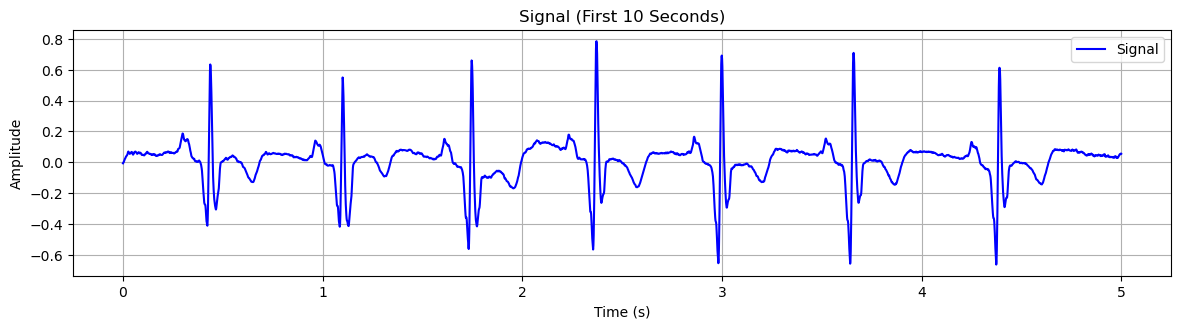

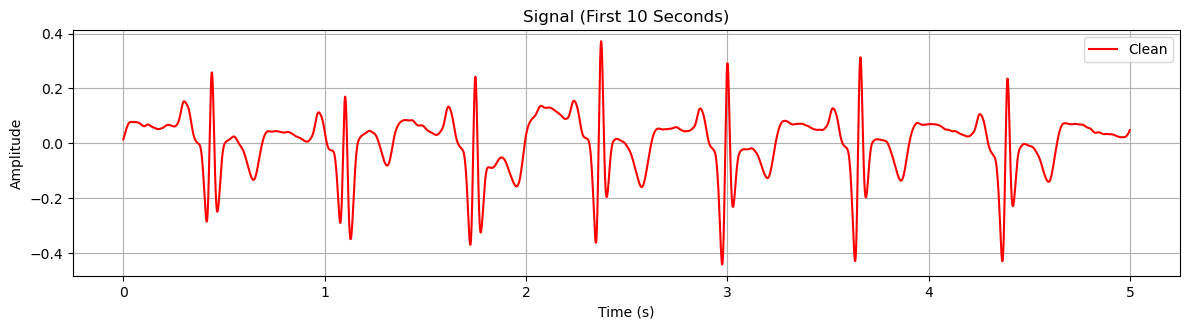

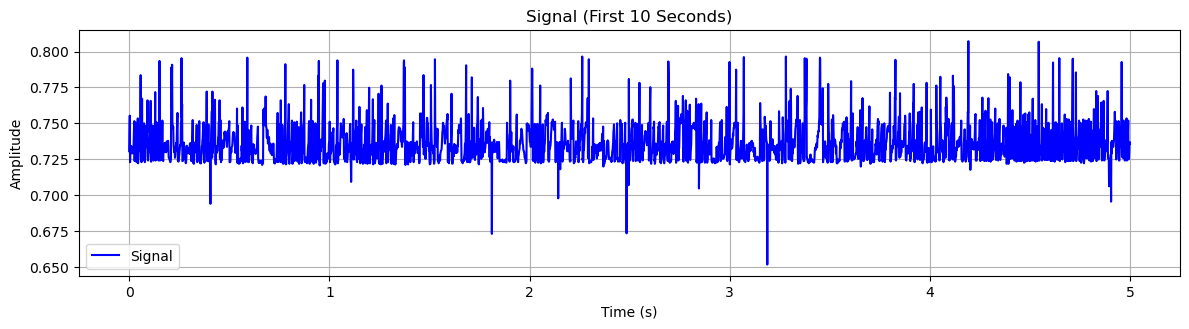

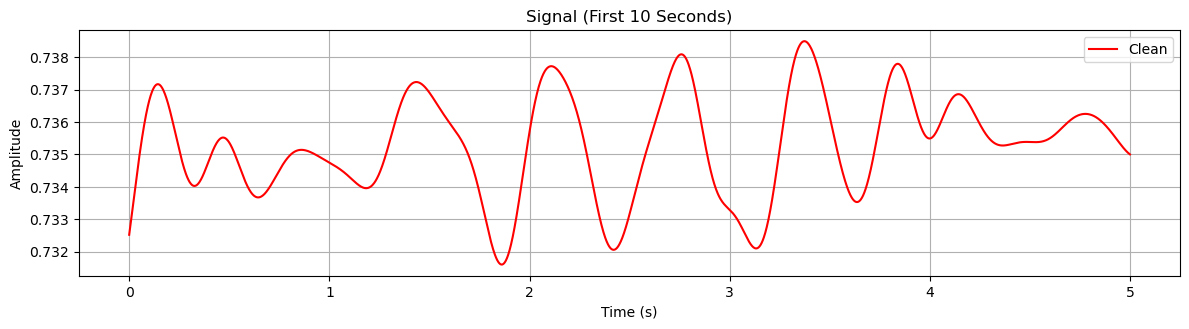

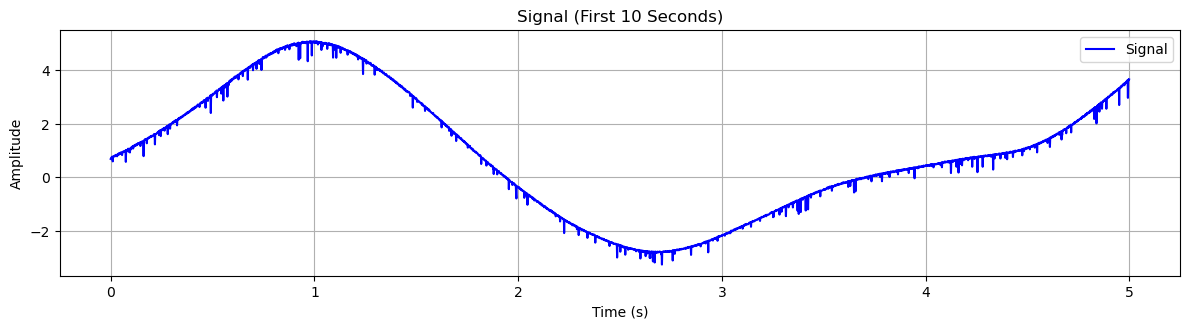

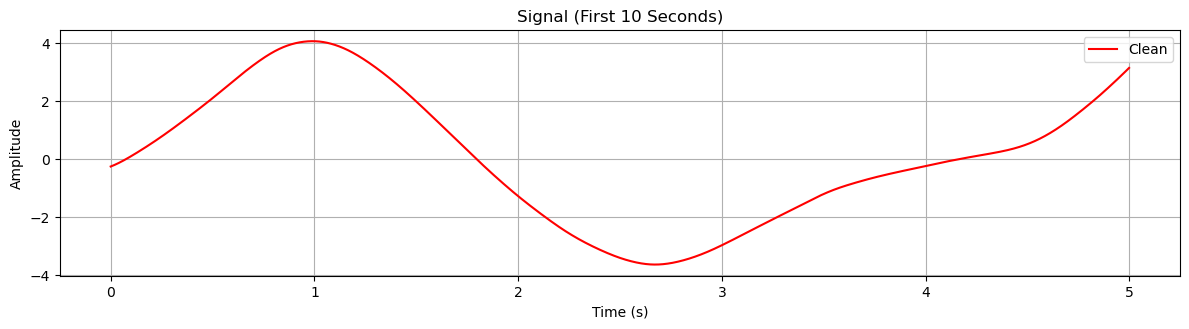

In [29]:
plot(ecg_np, 10)
plot(ecg_clean, 10, 'red', 'Clean')
plot(eda_np, 10)
plot(eda_clean, 10, 'red', 'Clean')
plot(resp_np, 10)
plot(resp_clean, 10, 'red', 'Clean')

### Saving cleaned data

In [ ]:
save_path = "E:\\saved2\\wesad_cleaned.pt"

torch.save({
    'ECG': ecg_clean,
    'EDA': eda_clean,
    'Resp': resp_clean,
    'labels': y_all
}, save_path)

print(f"Saved combined cleaned data to {save_path}")

In [ ]:
data = torch.load("E:\\saved\\wesad_cleaned.pt")

ecg_clean  = data['ECG']
eda_clean  = data['EDA']
resp_clean = data['Resp']
y_all    = data['labels']
lbl_np  = y_all   .cpu().numpy()
print("Data loaded:")
print("ECG shape:", ecg_clean.shape)
print("EDA shape:", eda_clean.shape)
print("Resp shape:", resp_clean.shape)
print("Labels shape:", y_all.shape)

### Data augmentation

In [7]:
import numpy as np

def add_jitter(signal, jitter=0.01):
    noise = np.random.uniform(-jitter, jitter, signal.shape)
    return signal + noise

def scale_signal(signal, min_scale=0.9, max_scale=1.1):
    scale_factor = np.random.uniform(min_scale, max_scale)
    return signal * scale_factor

def augment_signals_light(X, num_augmentations=1, jitter=0.005, min_scale=0.95, max_scale=1.05):
    augmented_X = []

    for signal in X:
        for _ in range(num_augmentations):
            jittered = np.array([add_jitter(s, jitter) for s in signal])
            scaled = np.array([scale_signal(s, min_scale, max_scale) for s in jittered])
            augmented_X.append(scaled)

    return np.array(augmented_X)



### Creating windows

In [ ]:
fs = 700
win_s = 5
win_len = win_s * fs
step_len = win_len // 2
n_samples = len(ecg_clean)
starts = range(0, n_samples - win_len + 1, step_len)
n_windows = len(list(starts))

X = np.zeros((n_windows, 3, win_len), dtype=np.float32)
y = np.zeros(n_windows, dtype=np.int64)
sid_win = np.zeros(n_windows, dtype=np.int64)

for i, start in enumerate(starts):
    end = start + win_len
    X[i, 0] = ecg_clean[start:end]
    X[i, 1] = eda_clean[start:end]
    X[i, 2] = resp_clean[start:end]

    
    label_slice = lbl_np[start:end]
    y[i] = np.bincount(label_slice, minlength=5)[1:5].argmax() + 1 # using majority voting to label each window

    # majority subject label too
    sid_slice = subj_id_np[start:end]
    sid_win[i] = np.bincount(sid_slice).argmax()

### Splitting data

In [ ]:
# Split data into training, validation, and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y)

val_size = 0.15 / 0.85  # 15% of the original set is for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=val_size, random_state=42, stratify=y_train_full)
y_val = (y_val - 1).astype(np.int64)
y_test = (y_test - 1).astype(np.int64)

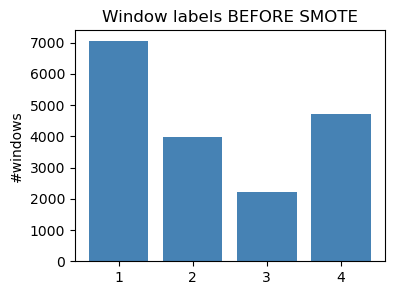

{1: 7045, 2: 3987, 3: 2228, 4: 4722}


In [12]:
labels, counts = np.unique(y, return_counts=True)
plt.figure(figsize=(4,3))
plt.bar(labels, counts, color='steelblue')
plt.title("Window labels BEFORE SMOTE")
plt.xticks(labels)
plt.ylabel("#windows")
plt.show()
print(dict(zip(labels, counts)))

### Applying SMOTE

In [15]:
# Apply SMOTE only on the training set
X_train_flat = X_train.reshape(X_train.shape[0], -1)
sm = SMOTE(random_state=42)
X_train_bal_flat, y_train_bal = sm.fit_resample(X_train_flat, y_train)
X_train_bal = X_train_bal_flat.reshape(-1, 3, win_len)
y_train_bal = (y_train_bal - 1).astype(np.int64)  # Zero-indexed labels for training
y_train = (y_train_full - 1).astype(np.int64)
print(f"Shapes → train {X_train_bal.shape[0]} | val {X_val.shape[0]} | test {X_test.shape[0]}")


Shapes → train 19724 | val 2698 | test 2698


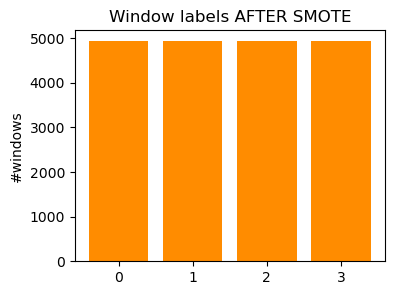

{0: 4931, 1: 4931, 2: 4931, 3: 4931}


In [16]:
labels_bal, counts_bal = np.unique(y_train_bal, return_counts=True)
plt.figure(figsize=(4, 3))
plt.bar(labels_bal, counts_bal, color='darkorange')
plt.title("Window labels AFTER SMOTE")
plt.xticks(labels_bal)
plt.ylabel("#windows")
plt.show()
print(dict(zip(labels_bal, counts_bal)))

### Creating Batches and passing to dataloader (And applying augmentation)

In [19]:
X_train_augmented_light = augment_signals_light(X_train_bal, num_augmentations=1, jitter=0.005, min_scale=0.95, max_scale=1.05)


In [22]:
X_train_combined_light = np.concatenate((X_train_bal, X_train_augmented_light), axis=0)
y_train_combined_light = np.concatenate((y_train_bal, y_train_bal), axis=0)  # Augment each class once
X_train_combined_light = X_train_combined_light.astype(np.float32)  ## making sure data is in an acceptable form for the model
y_train_combined_light = y_train_combined_light.astype(np.int64)

In [27]:
X_train_combined_light.shape

(39448, 3, 3500)

In [ ]:
batch_size = 16

train_ds_light = TensorDataset(torch.from_numpy(X_train_combined_light), torch.from_numpy(y_train_combined_light))
val_ds = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_ds = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_loader = DataLoader(train_ds_light, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
print("One batch ECG shape:", next(iter(train_loader))[0].shape)

### Model architcture 

In [31]:
class WESAD_CNN(nn.Module):
    def __init__(self, dropout_p=0.5):
        super().__init__()

        def conv_block(c_in, c_out):
            return nn.Sequential(
                nn.Conv1d(c_in, c_out, kernel_size=7, stride=1, padding=3),
                nn.BatchNorm1d(c_out),
                nn.ReLU(inplace=True),
                nn.MaxPool1d(kernel_size=4, stride=4)
            )

        self.extractor = nn.Sequential(
            conv_block(3, 32),
            conv_block(32, 64),
            conv_block(64, 128),
            conv_block(128, 256)
        )

        self.gap = nn.AdaptiveAvgPool1d(1) ## helps with reducing complexity
        self.dropout = nn.Dropout(dropout_p)
        self.classifier = nn.Linear(256, 4)

    def forward(self, x):
        x = self.extractor(x)
        x = self.gap(x).squeeze(-1)
        x = self.dropout(x)
        return self.classifier(x)


### Training Parameters

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WESAD_CNN(dropout_p=0.6).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True)


D:\software\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Training and validation Loop

In [34]:
n_epochs = 60
patience = 10
best_val = 0.0
epochs_no_improve = 0

train_hist, val_hist = [], []

for epoch in range(1, n_epochs + 1):
    model.train()
    tr_loss_sum, tr_correct, tr_total = 0.0, 0, 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        tr_loss_sum += loss.item() * xb.size(0)
        tr_correct += (out.argmax(1) == yb).sum().item()
        tr_total += yb.size(0)

    tr_loss = tr_loss_sum / tr_total
    tr_acc = tr_correct / tr_total

    model.eval()
    vl_loss_sum, vl_correct, vl_total = 0.0, 0, 0
    v_true, v_pred = [], []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)

            vl_loss_sum += loss.item() * xb.size(0)
            preds = out.argmax(1)
            vl_correct += (preds == yb).sum().item()
            vl_total += yb.size(0)

            v_true.append(yb.cpu())
            v_pred.append(preds.cpu())

    vl_loss = vl_loss_sum / vl_total
    vl_acc = vl_correct / vl_total
    scheduler.step(vl_loss)

    bal_acc = balanced_accuracy_score(torch.cat(v_true), torch.cat(v_pred))

    print(f"Epoch {epoch:02d} | train acc/loss {tr_acc:.3f}/{tr_loss:.3f} | "
          f"val acc/loss {vl_acc:.3f}/{vl_loss:.3f} | bal={bal_acc:.3f}")

    train_hist.append((tr_acc, tr_loss))
    val_hist.append((vl_acc, vl_loss))

    if vl_acc > best_val:
        best_val = vl_acc
        torch.save(model.state_dict(), "wesad_best.pt")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch}. Best val-acc = {best_val:.3f}")
            break

Epoch 01 | train acc/loss 0.482/1.142 | val acc/loss 0.584/0.923 | bal=0.638
Epoch 02 | train acc/loss 0.693/0.774 | val acc/loss 0.826/0.495 | bal=0.775
Epoch 03 | train acc/loss 0.790/0.554 | val acc/loss 0.854/0.422 | bal=0.846
Epoch 04 | train acc/loss 0.837/0.447 | val acc/loss 0.912/0.267 | bal=0.887
Epoch 05 | train acc/loss 0.866/0.373 | val acc/loss 0.914/0.254 | bal=0.900
Epoch 06 | train acc/loss 0.886/0.325 | val acc/loss 0.926/0.223 | bal=0.925
Epoch 07 | train acc/loss 0.896/0.294 | val acc/loss 0.926/0.210 | bal=0.911
Epoch 08 | train acc/loss 0.907/0.257 | val acc/loss 0.940/0.175 | bal=0.942
Epoch 09 | train acc/loss 0.914/0.245 | val acc/loss 0.944/0.161 | bal=0.934
Epoch 10 | train acc/loss 0.920/0.224 | val acc/loss 0.948/0.148 | bal=0.945
Epoch 11 | train acc/loss 0.925/0.210 | val acc/loss 0.943/0.160 | bal=0.945
Epoch 12 | train acc/loss 0.930/0.199 | val acc/loss 0.956/0.130 | bal=0.955
Epoch 13 | train acc/loss 0.934/0.188 | val acc/loss 0.950/0.151 | bal=0.949

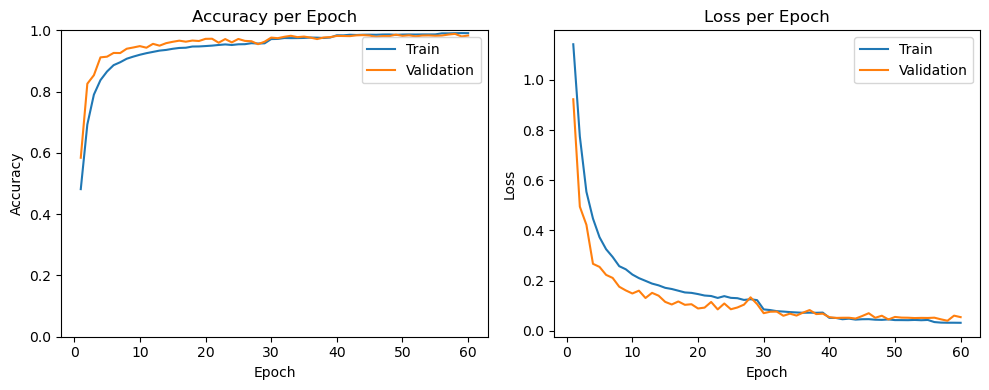

In [37]:
import matplotlib.pyplot as plt

# unpack accuracy and loss from the history lists
tr_acc  = [t[0] for t in train_hist]
tr_loss = [t[1] for t in train_hist]
vl_acc  = [v[0] for v in val_hist]
vl_loss = [v[1] for v in val_hist]

epochs = range(1, len(tr_acc) + 1)

plt.figure(figsize=(10,4))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_acc, label='Train')
plt.plot(epochs, vl_acc, label='Validation')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(epochs, tr_loss, label='Train')
plt.plot(epochs, vl_loss, label='Validation')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Testing and Results

In [39]:
model.load_state_dict(torch.load("wesad_best.pt"))
model.eval()
t_true, t_pred = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb)
        t_true.append(yb)
        t_pred.append(out.argmax(1).cpu())

t_true = torch.cat(t_true)
t_pred = torch.cat(t_pred)

print("\n=== TEST RESULTS ===")
print("Balanced accuracy :", balanced_accuracy_score(t_true, t_pred))
print(classification_report(t_true, t_pred, digits=3))

C:\Users\20112\AppData\Local\Temp\ipykernel_3804\2923694083.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("wesad_best.pt"))



=== TEST RESULTS ===
Balanced accuracy : 0.9786139370261266
              precision    recall  f1-score   support

           0      0.993     0.990     0.991      1057
           1      0.988     0.998     0.993       598
           2      0.949     0.949     0.949       334
           3      0.980     0.977     0.979       709

    accuracy                          0.983      2698
   macro avg      0.978     0.979     0.978      2698
weighted avg      0.983     0.983     0.983      2698



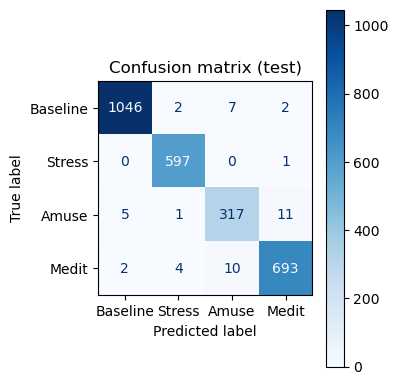

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay

class_names = ['Baseline', 'Stress', 'Amuse', 'Medit']   
cm = confusion_matrix(t_true, t_pred)

fig, ax = plt.subplots(figsize=(4,4))
ConfusionMatrixDisplay(cm, display_labels=class_names)\
        .plot(cmap='Blues', ax=ax, values_format='d')    
ax.set_title("Confusion matrix (test)")
plt.tight_layout()
plt.show()

### Visualizing the Model using TensorBoard

In [71]:
model = WESAD_CNN()


writer = SummaryWriter(log_dir="runs/cnn_visualization")


dummy_input = torch.randn(1, 3, 3500)

# Add the graph to TensorBoard
writer.add_graph(model, dummy_input)
writer.close()

In [ ]:
!tensorboard --logdir=runs/cnn_visualization --port=6006
